## Closed-form Solution for Ridge Regression}


$$ \arg \min_{\beta} L(\beta), \quad \text{where} \quad L(\beta) = \|y - X\beta\|_2^2 + \lambda \|\beta\|_2^2,$$

with $\lambda \ge 0$, $y \in \mathbb{R}^n$, $X \in \mathbb{R}^{n \times p}$, and $\beta \in \mathbb{R}^p$.

$$
L(\beta) = (y - X\beta)^\top (y - X\beta) + \lambda \beta^\top \beta$$


$$
(y - X\beta)^\top (y - X\beta) = y^\top y - 2 y^\top X \beta + \beta^\top X^\top X \beta
$$


$$
L(\beta) = y^\top y - 2 y^\top X \beta + \beta^\top X^\top X \beta + \lambda \beta^\top \beta
$$

Compute the gradients w.r.t $\beta$:
$$\begin{align*}
\nabla_\beta(y^\top y) &= 0 \\
\nabla_\beta(-2 y^\top X \beta) &= -2 X^\top y \\
\nabla_\beta(\beta^\top X^\top X \beta) &= 2 X^\top X \beta \\
\nabla_\beta(\lambda \beta^\top \beta) &= 2 \lambda \beta
\end{align*}$$

So the gradient of $L(\beta)$ is:
$$
\nabla_\beta L(\beta) = -2 X^\top y + 2 X^\top X \beta + 2 \lambda \beta
$$


Setting the gradient equal to zero:
$$-2 X^\top y + 2 X^\top X \beta + 2 \lambda \beta = 0$$

Divide through by 2 and rearrange:
$$(X^\top X + \lambda I)\beta = X^\top y $$

Solve for $(\beta)$
assuming $(X^\top X + \lambda I)$ is invertible:
$$\hat{\beta}_{\text{ridge}} = (X^\top X + \lambda I)^{-1} X^\top y$$

## Invertibility

- $X^\top X$ is symmetric positive semidefinite: $v^\top X^\top X v = \|X v\|_2^2 \ge 0$  
- For $\lambda > 0$:
$$
v^\top (X^\top X + \lambda I) v = \|X v\|_2^2 + \lambda \|v\|_2^2 > 0 \quad \forall v \neq 0
$$
Hence, $X^\top X + \lambda I$ is strictly positive definite and invertible, even if $X$ is not full rank.

- Ridge regression stabilizes the inversion by adding $\lambda I$ to $X^\top X$.  
- It shrinks coefficients toward zero and improves numerical conditioning, especially in cases of multicollinearity.

### Example

Start with the matrix

$
X^T X =
\begin{pmatrix}
2 & 4\\[4pt]
3 & 6
\end{pmatrix}.
$

Its determinant is

$
\det(X^T X) = 2 \cdot 6 - 3 \cdot 4 = 12 - 12 = 0,
$
so $X^T X$ is *not invertible*.

Now add a regularization term $\lambda I$:

$
\lambda I =
\begin{pmatrix}
\lambda & 0\\[4pt]
0 & \lambda
\end{pmatrix}.
$

Let’s choose $\lambda = 1$. Then

$
X^T X + \lambda I =
\begin{pmatrix}
2 & 4\\[4pt]
3 & 6
\end{pmatrix}
+
\begin{pmatrix}
1 & 0\\[4pt]
0 & 1
\end{pmatrix}
=
\begin{pmatrix}
3 & 4\\[4pt]
3 & 7
\end{pmatrix}.
$

Compute the determinant:

$
\det(X^T X + \lambda I)
= 3 \cdot 7 - 3 \cdot 4
= 21 - 12
= 9 \neq 0.
$

And it becomes invertible hence the determinant is not 0.


## 1. Download the dataset

In [399]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

# 2. Apply Ridge and Lasso Regression
## a.Split the data into a training set and a test set.

In [401]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## b.Standardize the features before fitting the model.

In [402]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## c.Fit ridge and lasso regression models using Python’s sklearn library.

In [403]:
from sklearn.metrics import mean_squared_error
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError

def fit_and_report(model, X_train, X_test, y_train, y_test, *, report_name=None):
    """Helper function for evaluating models"""
    try:
        check_is_fitted(model)
    except NotFittedError:
        model.fit(X_train, y_train)

    return {
        "model": report_name if report_name is not None else model.__class__.__name__, 
        "alpha": getattr(model, 'alpha_', None) or model.alpha, 
        "mse_train": mean_squared_error(y_train, model.predict(X_train)), 
        "mse_test": mean_squared_error(y_test, model.predict(X_test))
    }

In [404]:
from sklearn.linear_model import Ridge, Lasso

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train);

lasso_model = Lasso(alpha=1.0, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train);

In [405]:
basic_ridge_lasso_comparison = pd.DataFrame([
    fit_and_report(ridge_model, X_train_scaled, X_test_scaled, y_train, y_test, report_name="Base Ridge"), 
    fit_and_report(lasso_model, X_train_scaled, X_test_scaled, y_train, y_test, report_name="Base Lasso")
]).set_index("model")

basic_ridge_lasso_comparison

,alpha,mse_train,mse_test
model,,,
Base Ridge,1.0,0.523358,0.530544
Base Lasso,1.0,1.339696,1.312545


- With base(default) value for alpha, Ridge seems to outperform Lasso. 

In [406]:
pd.DataFrame({
    "Base Ridge coefs": [ridge_model.intercept_] + list(ridge_model.coef_),
    "Base Lasso coefs": [ridge_model.intercept_] + list(ridge_model.coef_),
}, index=["Intercept"] + list(X.columns))

,Base Ridge coefs,Base Lasso coefs
Intercept,2.069240,2.069240
MedInc,0.849152,0.849152
HouseAge,0.122208,0.122208
AveRooms,-0.299309,-0.299309
AveBedrms,0.348103,0.348103
Population,-0.000854,-0.000854
AveOccup,-0.041702,-0.041702
Latitude,-0.893003,-0.893003
Longitude,-0.867752,-0.867752


## d. Use cross-validation to tune the hyperparameter 𝜆 (also referred to as 𝛼 in sklearn).

In [407]:
import numpy as np 
from sklearn.linear_model import RidgeCV, LassoCV

ridge_alphas = np.logspace(-10, 3, 100)
lasso_alphas = np.logspace(-10, 3, 100)
ridge_model_cv = RidgeCV(alphas=ridge_alphas, cv=10)
lasso_model_cv = LassoCV(alphas=lasso_alphas, cv=10, max_iter=10000)

# 3. Compare the performance of Ridge and Lasso Regression:

### Report the mean squared error (MSE) on both the training and test sets.

In [408]:
ridge_report_dict = fit_and_report(ridge_model_cv,  X_train_scaled, X_test_scaled, y_train, y_test, report_name = "Ridge")
lasso_report_dict = fit_and_report(lasso_model_cv, X_train_scaled, X_test_scaled, y_train, y_test, report_name = "Lasso")

ridge_lasso_comparison = pd.DataFrame([ridge_report_dict, lasso_report_dict]).set_index("model")

ridge_lasso_comparison

,alpha,mse_train,mse_test
model,,,
Ridge,2.364489,0.523358,0.530511
Lasso,0.000911,0.523404,0.529814


- Both models perform very similarly and their train MSEs differ by less than around 0.001.
- However, Lasso slightly outperforms Ridge on the test set.
- The Ridge model seems to be overfitting slighly given it's train MSE is lower than the test MSE. (confirmed by the plot at the end)


## b.Compare the coefficients obtained from both methods.


In [409]:
coef_df = pd.DataFrame({
    "Ridge coefs": [ridge_model_cv.intercept_] + list(ridge_model_cv.coef_),
    "Lasso coefs": [lasso_model_cv.intercept_] + list(lasso_model_cv.coef_),
}, index=["Intercept"] + list(X.columns))

In [410]:
coef_df

,Ridge coefs,Lasso coefs
Intercept,2.069240,2.069240
MedInc,0.849057,0.844379
HouseAge,0.122330,0.122774
AveRooms,-0.298969,-0.287059
AveBedrms,0.347684,0.335809
Population,-0.000813,-0.000000
AveOccup,-0.041708,-0.040812
Latitude,-0.891843,-0.884021
Longitude,-0.866576,-0.858154


- Both models assign very similar coefficient values, showing that the predictors influence the outcome in nearly the same way.

- Lasso Regression applies stronger shrinkage and even eliminates the “Population” variable (coefficient = 0). For Ridge it is also close to 0 but Lasso brings it to 0 given its feature selection ability.

- Ridge Regression keeps all coefficients nonzero, spreading the penalty more evenly.

### Explore MSE vs alpha

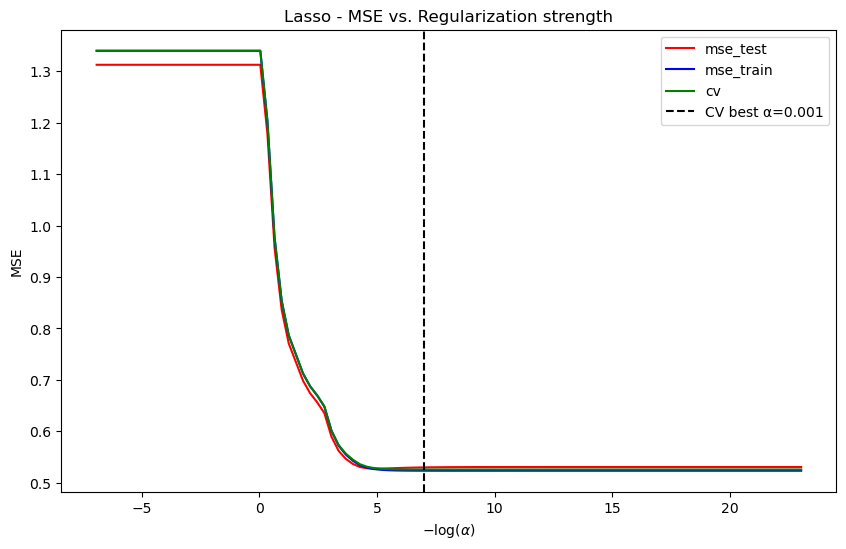

In [411]:
colors = ["red", "blue", "green"]

lasso_mse_list = [
    fit_and_report(Lasso(alpha=alpha, max_iter=10000), X_train_scaled, X_test_scaled, y_train, y_test)
    for alpha in lasso_alphas
]

lasso_mse = pd.DataFrame(lasso_mse_list)
lasso_mse["log_alpha"] = -np.log(lasso_alphas)

lasso_mse["cv"] = [
    -np.mean(cross_val_score(
        Lasso(alpha=alpha, max_iter=10000),
        X_train_scaled, 
        y_train, 
        cv=10,
        scoring='neg_mean_squared_error'
    ))
    for alpha in lasso_alphas
]

fig, ax = plt.subplots(figsize=(10,6))
lasso_mse.plot(x="log_alpha", y="mse_test", color=colors[0], ax=ax)
lasso_mse.plot(x="log_alpha", y="mse_train", color=colors[1], ax=ax)
lasso_mse.plot(x="log_alpha", y="cv", color=colors[2], ax=ax)

ax.axvline(-np.log(lasso_model_cv.alpha_), color='black', linestyle='--', label=f'CV best α={lasso_model_cv.alpha_:.3f}')
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
plt.legend()
plt.title("Lasso - MSE vs. Regularization strength")

plt.show()

In [416]:
lasso_mse.loc[lasso_mse['cv'].idxmin()]

model           Lasso
alpha        0.000911
mse_train    0.523404
mse_test     0.529814
log_alpha    7.000789
cv           0.525669
Name: 53, dtype: object

For Lasso - seems for alphas greater than around -log(5), the model performance is similar.

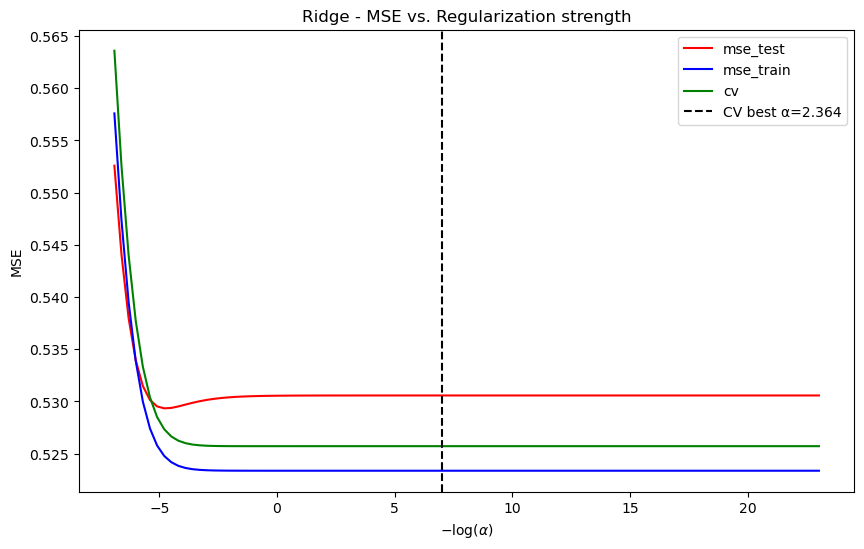

In [412]:
ridge_mse_list = [
    fit_and_report(Ridge(alpha=alpha), X_train_scaled, X_test_scaled, y_train, y_test)
    for alpha in ridge_alphas
]

ridge_mse = pd.DataFrame(ridge_mse_list)
ridge_mse["log_alpha"] = -np.log(ridge_alphas)

ridge_mse["cv"] = [
    -np.mean(cross_val_score(
        Ridge(alpha=alpha), 
        X_train_scaled, 
        y_train, 
        cv=10, 
        scoring='neg_mean_squared_error'
    ))
    for alpha in ridge_alphas
]

fig, ax = plt.subplots(figsize=(10,6))
ridge_mse.plot(x="log_alpha", y="mse_test", color=colors[0], ax=ax)
ridge_mse.plot(x="log_alpha", y="mse_train", color=colors[1], ax=ax)
ridge_mse.plot(x="log_alpha", y="cv", color=colors[2], ax=ax)

ax.axvline(-np.log(lasso_model_cv.alpha_), color='black', linestyle='--', label=f'CV best α={ridge_model_cv.alpha_:.3f}')
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
plt.legend()
plt.title("Ridge - MSE vs. Regularization strength")

plt.show()

For Ridge - seems the alpha for which CV results are the best leads to a bit of overfitting (as mentioned in the comparison table before). Maybe a higher alpha (stronger regularization) could result in a better test MSE score. 

In [415]:
ridge_mse.loc[ridge_mse['cv'].idxmin()]

model           Ridge
alpha        2.364489
mse_train    0.523358
mse_test     0.530511
log_alpha   -0.860562
cv            0.52571
Name: 79, dtype: object